Adapted from Chris Tralie's CS 477 at Ursinus College

In [2]:
# Import libraries
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.layers import Dense, Conv2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import string
import time
import numpy as np
import matplotlib.pyplot as plt
import skimage.io
from skimage.transform import resize
import glob

/opt/miniconda3/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
imgres = 64

# Setup model
class AutoencoderCNN(Model):
    def __init__(self, imgres, d, k):
        """
        Parameters
        ----------
        imgres: int
            Resolution of each grayscale image
        d: int
            Dimension of the embedding
        k: int
            Kernel size at each layer
        """
        super(AutoencoderCNN, self).__init__()
        self.imgres = imgres
        self.d = d
        self.k = k
        self.encoder = Sequential([
            layers.Input(shape=(imgres, imgres, 1)),
            layers.Conv2D(32, (k, k), activation='relu', padding='same', strides=2),
            layers.Dropout(0.2),
            layers.Conv2D(64, (k, k), activation='relu', padding='same', strides=2),
            layers.Dropout(0.2),
            layers.Conv2D(128, (k, k), activation='relu', padding='same', strides=2),
            layers.Dropout(0.2),
            layers.Flatten(),
            layers.Dense(d, activation='relu')
        ])
        
        self.decoder = Sequential([
            layers.Input(shape=(d,)),
            layers.Dense(2*imgres**2),
            layers.Reshape((imgres//8, imgres//8, 128)),
            layers.Conv2DTranspose(128, kernel_size=k, strides=2, activation='relu', padding='same'),
            layers.Dropout(0.2),
            layers.Conv2DTranspose(64, kernel_size=k, strides=2, activation='relu', padding='same'),
            layers.Dropout(0.2),
            layers.Conv2DTranspose(32, kernel_size=k, strides=2, activation='relu', padding='same'),
            layers.Dropout(0.2),
            layers.Conv2DTranspose(1, kernel_size=(k, k), activation='sigmoid', padding='same')
        ])
    
    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


autoencoder = AutoencoderCNN(imgres=imgres, d=128, k=3)
print(autoencoder.encoder.summary())
print(autoencoder.decoder.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        320       
                                                                 
 dropout (Dropout)           (None, 32, 32, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 dropout_1 (Dropout)         (None, 16, 16, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 128)         73856     
                                                                 
 dropout_2 (Dropout)         (None, 8, 8, 128)         0         
                                                                 
 flatten (Flatten)           (None, 8192)              0

In [4]:
class PlotterCallback(tf.keras.callbacks.Callback):
    def __init__(self, n=10):
        self.epoch = 0
        self.n = n
        self.plot_imgs = datagen.flow_from_directory('../bonus/autoencoder/Valid'.format(imgres, imgres),
        class_mode="input", batch_size=n, shuffle=True,
        target_size=(imgres, imgres), color_mode="grayscale")
        self.X = self.plot_imgs.next()[0]
    
    def on_epoch_end(self, epoch, logs=None):
        keys = list(logs.keys())
        print("End epoch {} of training; got log keys: {}".format(epoch, keys))
        X = self.X
        encoded_imgs = autoencoder.encoder(X).numpy()
        print(encoded_imgs.shape)
        decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()
        plt.figure(figsize=(20, 5))
        n = self.n
        for i in range(n):
            # display original
            plt.subplot(3, n, i + 1)
            plt.imshow(X[i, :, :, 0], cmap='gray')
            plt.title("original")
            plt.axis("off")

            # display reconstruction
            plt.subplot(3, n, n+i+1)
            plt.imshow(decoded_imgs[i], cmap='gray')
            plt.title("reconstructed")
            plt.axis("off")

            # display difference
            plt.subplot(3, n, 2*n+i+1)
            plt.imshow(X[i, :, :, :] - decoded_imgs[i], cmap='gray')
            plt.title("Difference")
            plt.axis("off")
        self.epoch += 1
        plt.savefig("Epoch{}.png".format(self.epoch), bbox_inches='tight')
        plt.show()

Found 9381 images belonging to 1 classes.
Found 94 images belonging to 1 classes.


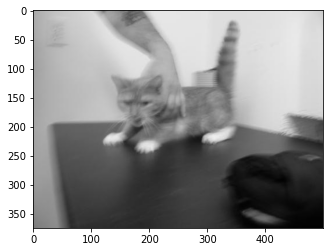

In [5]:

img = load_img('../bonus/autoencoder/Train/0.jpg') 
plt.imshow(img, cmap='gray')

datagen = ImageDataGenerator(rescale=1/255)
train_it = datagen.flow_from_directory('../bonus/autoencoder/Train'.format(imgres, imgres),
        class_mode="input", batch_size=64, shuffle=True,
        target_size=(imgres, imgres), color_mode="grayscale")
test_it = datagen.flow_from_directory('../bonus/autoencoder/Valid'.format(imgres, imgres),
        class_mode="input", batch_size=64, shuffle=True,
        target_size=(imgres, imgres), color_mode="grayscale")

Found 94 images belonging to 1 classes.
Epoch 1/25
147/147 [==============================] - ETA: 0s - loss: 0.0376End epoch 0 of training; got log keys: ['loss', 'val_loss']
(10, 128)


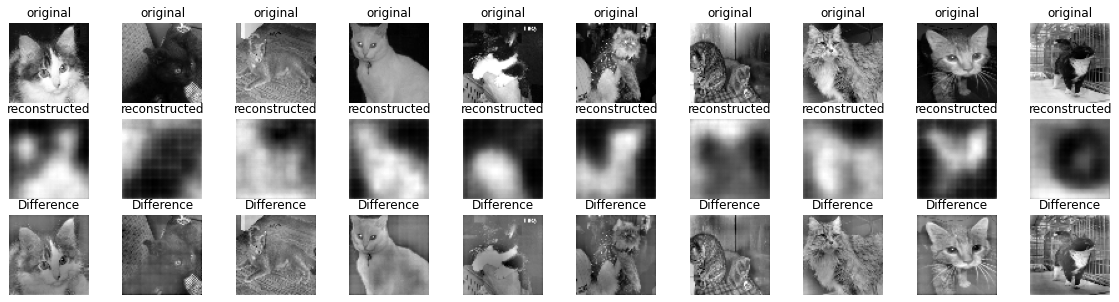

147/147 [==============================] - 113s 758ms/step - loss: 0.0376 - val_loss: 0.0204
Epoch 2/25
147/147 [==============================] - ETA: 0s - loss: 0.0200End epoch 1 of training; got log keys: ['loss', 'val_loss']
(10, 128)


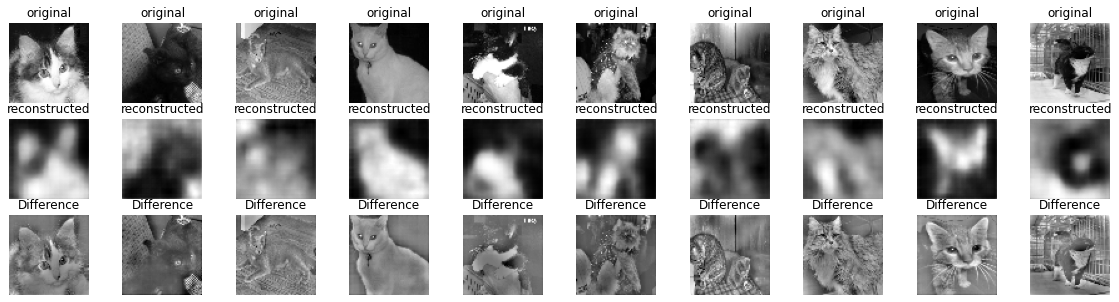

147/147 [==============================] - 1124s 8s/step - loss: 0.0200 - val_loss: 0.0156
Epoch 3/25
147/147 [==============================] - ETA: 0s - loss: 0.0170  End epoch 2 of training; got log keys: ['loss', 'val_loss']
(10, 128)


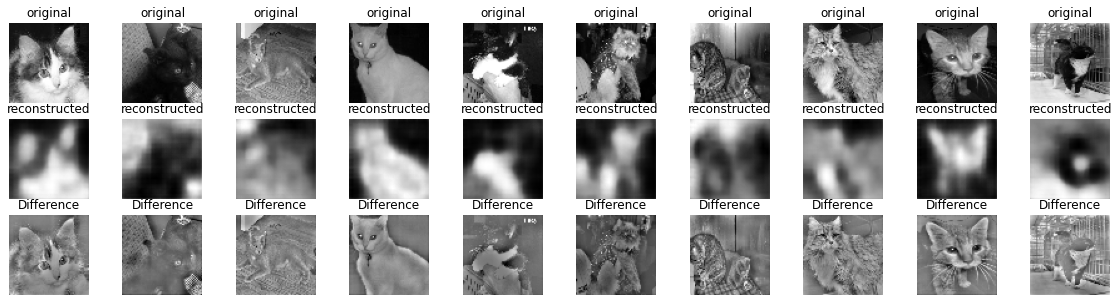

147/147 [==============================] - 21145s 145s/step - loss: 0.0170 - val_loss: 0.0137
Epoch 4/25
147/147 [==============================] - ETA: 0s - loss: 0.0153End epoch 3 of training; got log keys: ['loss', 'val_loss']
(10, 128)


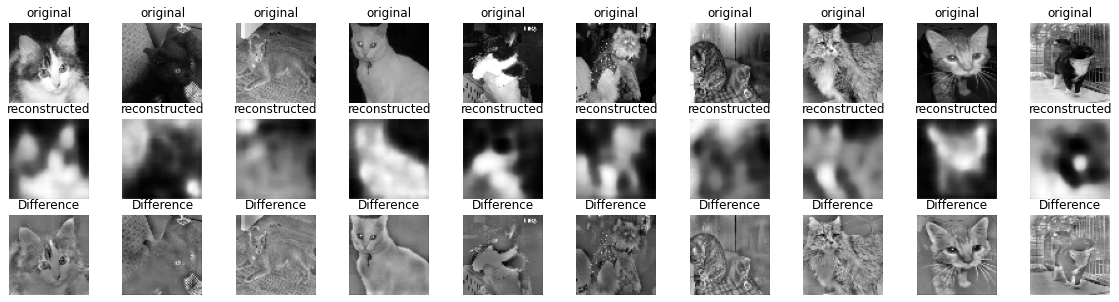

147/147 [==============================] - 217s 1s/step - loss: 0.0153 - val_loss: 0.0127
Epoch 5/25
147/147 [==============================] - ETA: 0s - loss: 0.0143End epoch 4 of training; got log keys: ['loss', 'val_loss']
(10, 128)


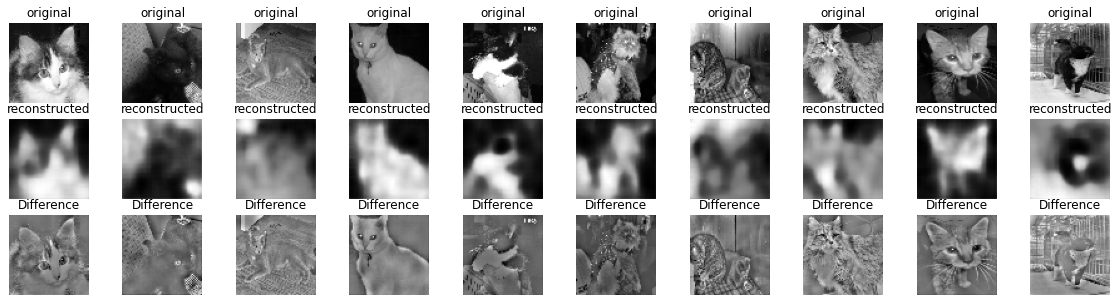

147/147 [==============================] - 204s 1s/step - loss: 0.0143 - val_loss: 0.0120
Epoch 6/25
147/147 [==============================] - ETA: 0s - loss: 0.0136End epoch 5 of training; got log keys: ['loss', 'val_loss']
(10, 128)


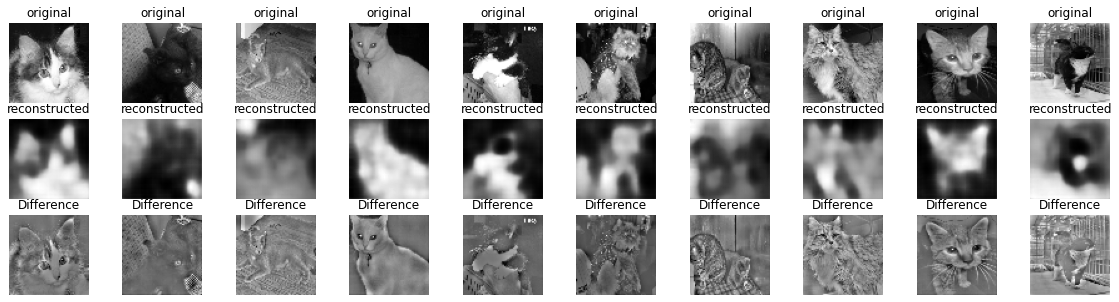

147/147 [==============================] - 377s 3s/step - loss: 0.0136 - val_loss: 0.0113
Epoch 7/25
147/147 [==============================] - ETA: 0s - loss: 0.0130End epoch 6 of training; got log keys: ['loss', 'val_loss']
(10, 128)


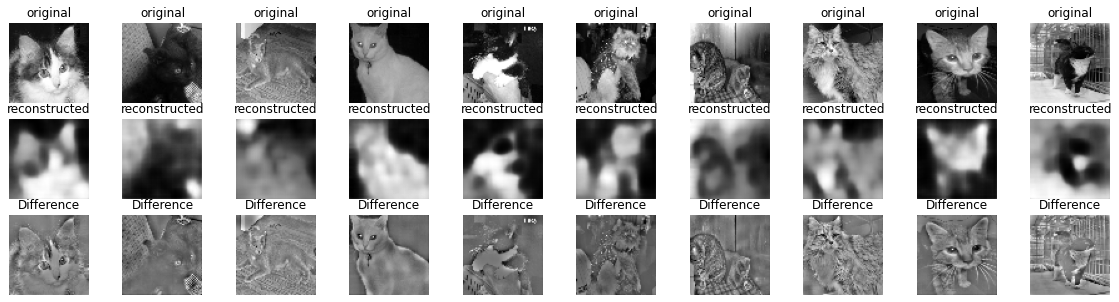

147/147 [==============================] - 153s 1s/step - loss: 0.0130 - val_loss: 0.0107
Epoch 8/25
107/147 [====================>.........] - ETA: 40s - loss: 0.0128

In [ ]:
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())
history = autoencoder.fit(train_it, 
                           steps_per_epoch=len(train_it),
                           validation_data=test_it,
                           validation_steps=len(test_it),
                           epochs=25,
                           verbose=1,
                           callbacks=[PlotterCallback()])

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Data', 'Test Data'], loc='upper left')

In [ ]:
noise = np.random.randn(1, 128)
print(noise)
plt.imshow(noise, cmap='gray')

In [ ]:

x = autoencoder.decoder(noise).numpy()

plt.imshow(x[0, :, :, 0], cmap='gray')

In [ ]:
autoencoder.save_weights("models/catautoencoder")